### NLP Preprocessing and Dataset Setup

1. **Libraries Imported**  
   - Used for data handling, preprocessing, visualization, and modeling.  
   - Includes libraries like NLTK, scikit-learn, Gensim, and Matplotlib.

2. **Resources Downloaded**  
   - NLTK resources for text preprocessing (stopwords, lemmatization).  
   - GloVe embeddings (`glove-twitter-25`) for word representations.

3. **Dataset Loaded**  
   - `cardiffnlp/tweet_eval` hate-speech dataset split into training and testing dataframes.

4. **Dataset Insights**  
   - Displays training and testing sample counts.  
   - Shows class distribution in the training set for label balance analysis.

In [2]:
# Import required libraries
import pandas as pd  
# For data manipulation and analysis, particularly to handle the dataset in tabular form

import numpy as np   
# For numerical operations, such as array manipulations or mathematical computations

from datasets import load_dataset 
#To load the cardiffnlp/tweet_eval dataset, which contains tweets labeled for hate speech.

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

'''
nltk: The Natural Language Toolkit, used for text preprocessing tasks like tokenization, stopword removal, and lemmatization.
stopwords: A module from NLTK to access a list of common words (e.g., "the," "is") that are often removed in NLP tasks.
WordNetLemmatizer: A module from NLTK for lemmatizing words (e.g., converting "running" to "run"). '''

import re

'''For regular expressions, used to clean and preprocess text data (e.g., removing special characters or URLs).'''



from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
'''TfidfVectorizer: Converts text into a TF-IDF (Term Frequency-Inverse Document Frequency) matrix, 
which represents text as numerical features based on word importance.'''


# CountVectorizer: Converts text into a bag-of-words model, counting word occurrences.

from sklearn.linear_model import LogisticRegression
# A machine learning model for binary or multiclass classification (likely used here for hate speech detection).

from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix

# sklearn.metrics: Provides evaluation metrics for model performance:

# classification_report: Generates precision, recall, and F1-score for each class.
# accuracy_score: Computes the overall accuracy of predictions.
# roc_curve, auc: For evaluating model performance using Receiver Operating Characteristic curves and Area Under the Curve.
# confusion_matrix: To visualize true vs. predicted labels in a matrix.


import matplotlib.pyplot as plt
# For creating visualizations, such as plots for model evaluation.

import seaborn as sns
#Enhances Matplotlib visualizations (e.g., for prettier heatmaps of confusion matrices).


from gensim.models import Word2Vec, FastText
# gensim.models: Provides tools for word embeddings:

# Word2Vec: A model to create word embeddings based on word co-occurrences in the dataset.
# FastText: An extension of Word2Vec that considers subword information for better handling of rare words.

import gensim.downloader as api
# Allows downloading pretrained word embeddings, such as GloVe


# Download required NLTK resources and GloVe embeddings
nltk.download(['stopwords', 'wordnet', 'omw-1.4'])

'''stopwords: Downloads a list of common words (e.g., "and," "or") to be removed during preprocessing, 

as they often add little meaning in NLP tasks.
wordnet: Downloads WordNet, 

a lexical database used for lemmatization (reducing words to their base form, e.g., "better" to "good").

omw-1.4: Downloads the Open Multilingual WordNet, an extension of WordNet for multilingual support.'''


glove_vectors = api.load('glove-twitter-25')  # Using Twitter GloVe
# Downloads pretrained GloVe (Global Vectors for Word Representation) embeddings trained on Twitter data, with 25-dimensional vectors.

# GloVe embeddings represent words as dense vectors, capturing semantic relationships (e.g., "king" and "queen" have similar vectors).

# The glove-twitter-25 model is lightweight and tailored for Twitter data, making it suitable for the tweet-based dataset.



# Load dataset
# The code loads the cardiffnlp/tweet_eval dataset, 
# specifically the hate-speech subset, and converts it into Pandas DataFrames for easier manipulation:


dataset = load_dataset("cardiffnlp/tweet_eval", "hate")
# Uses the Hugging Face datasets library to load the hate-speech dataset from the tweet_eval collection.
# The dataset contains tweets labeled as hate speech (positive class) or non-hate speech (negative class).



train_df = pd.DataFrame({'text': dataset['train']['text'], 'label': dataset['train']['label']})
'''Creates a Pandas DataFrame for the training split, with two columns:

text: The tweet content.
label: The corresponding label (e.g., 0 for non-hate speech, 1 for hate speech).'''

test_df = pd.DataFrame({'text': dataset['test']['text'], 'label': dataset['test']['label']})
# Similarly creates a DataFrame for the test split.

 
# Purpose: This step organizes the dataset into a structured format (DataFrames) for preprocessing, analysis, and model training.

# Print dataset information
print("Dataset Overview:")
print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")
print("\nClass distribution in training set:")
print(train_df['label'].value_counts(normalize=True).round(3))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sourabhkapure/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sourabhkapure/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/sourabhkapure/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Dataset Overview:
Training samples: 9000
Testing samples: 2970

Class distribution in training set:
label
0    0.58
1    0.42
Name: proportion, dtype: float64


### Text Preprocessing for Tweets

1. **Preprocessing Function**  
   - **Handles Invalid Input**: Returns an empty string for non-string or blank text.  
   - **Converts to Lowercase**: Ensures uniformity in text.  
   - **Cleans Twitter Elements**:  
     - Replaces URLs with "URL".  
     - Mentions replaced with "USER".  
     - Removes hashtags while keeping the text.  
   - **Removes Noise**: Eliminates special characters, numbers, and non-alphabetic tokens.  
   - **Stopword Removal**: Retains important negations like "not", "no", "never".  
   - **Lemmatization**: Reduces words to their base forms for consistency.

2. **Safe Preprocessing**  
   - Applies preprocessing to datasets while handling errors gracefully.  
   - Ensures a new column (`processed_text`) is added with cleaned text.

3. **Preprocessing Applied**  
   - Processes both training and testing datasets using the defined functions.

In [3]:
def preprocess_text(text):
    """Simple preprocessing function for tweets"""
    # Handle empty or invalid input
    if not isinstance(text, str) or not text.strip():
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Handle special Twitter elements
    text = re.sub(r'http\S+|www\S+|https\S+', 'URL', text)
    text = re.sub(r'@\w+', 'USER', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Simple tokenization
    tokens = text.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english')) - {'not', 'no', 'never'}
    tokens = [token for token in tokens if token not in stop_words]
    
    # Remove short and non-alphabetic tokens
    tokens = [token for token in tokens if token.isalpha() and len(token) > 2]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

# Preprocess with error handling
def safe_preprocess(df):
    try:
        df['processed_text'] = df['text'].apply(preprocess_text)
    except Exception as e:
        print(f"Error during preprocessing: {e}")
        df['processed_text'] = df['text']
    return df

# Apply preprocessing
train_df = safe_preprocess(train_df)
test_df = safe_preprocess(test_df)

### Creating Text Embeddings

1. **Bag of Words (BoW)**  
   - Uses `CountVectorizer` with a maximum of 5000 features.  
   - Transforms training and testing text data into BoW vectors.  

2. **TF-IDF (Term Frequency-Inverse Document Frequency)**  
   - Employs `TfidfVectorizer` with a maximum of 5000 features.  
   - Converts text data into TF-IDF representations for training and testing.

3. **Word2Vec Embeddings**  
   - Trains a `Word2Vec` model on tokenized tweets from the training dataset.  
   - Parameters:  
     - Vector size: 100.  
     - Context window: 5.  
     - Minimum word count: 2.  
     - Uses 4 parallel workers for training.

4. **FastText Embeddings**  
   - Trains a `FastText` model on tokenized tweets.  
   - Same parameters as Word2Vec for vector size, window size, and word count.

5. **Document Vector Creation**  
   - Averages word vectors to form document-level embeddings:  
     - **Word2Vec** and **FastText** embeddings are created using the trained models.  
     - **GloVe Embeddings** are utilized from pre-trained vectors (Twitter GloVe with size 25).  
   - Returns a zero vector if no valid word vectors are found in the text.

6. **Generated Embeddings**  
   - For all methods (Word2Vec, FastText, GloVe):  
     - Training (`X_train_*`) and testing (`X_test_*`) embeddings are created.

In [4]:
# Diagnose GloVe model structure and capabilities
print("=== GloVe Model Diagnostics ===")
print(f"GloVe model type: {type(glove_vectors)}")
print(f"GloVe vector dimensions: {glove_vectors.vector_size}")
print(f"Vocabulary size: {len(glove_vectors.key_to_index) if hasattr(glove_vectors, 'key_to_index') else 'Unknown'}")

# Test some common words
test_words = ['good', 'bad', 'hate', 'love', 'user', 'url', 'the', 'and']
print("\n=== Testing word access ===")
for word in test_words:
    try:
        if hasattr(glove_vectors, 'key_to_index'):
            if word in glove_vectors.key_to_index:
                vec = glove_vectors[word]
                print(f"✓ '{word}': found, vector shape {vec.shape}")
            else:
                print(f"✗ '{word}': not found in vocabulary")
        elif word in glove_vectors:
            vec = glove_vectors[word]
            print(f"✓ '{word}': found, vector shape {vec.shape}")
        else:
            print(f"✗ '{word}': not found")
    except Exception as e:
        print(f"✗ '{word}': error - {e}")

# Check sample preprocessed text
print(f"\n=== Sample preprocessed texts ===")
for i, text in enumerate(train_df['processed_text'].head(3)):
    print(f"Sample {i+1}: '{text[:50]}...'")
    words = text.split()
    print(f"  Words: {words[:10]}")
    
print("=== End Diagnostics ===\n")

=== GloVe Model Diagnostics ===
GloVe model type: <class 'gensim.models.keyedvectors.KeyedVectors'>
GloVe vector dimensions: 25
Vocabulary size: 1193514

=== Testing word access ===
✓ 'good': found, vector shape (25,)
✓ 'bad': found, vector shape (25,)
✓ 'hate': found, vector shape (25,)
✓ 'love': found, vector shape (25,)
✓ 'user': found, vector shape (25,)
✓ 'url': found, vector shape (25,)
✓ 'the': found, vector shape (25,)
✓ 'and': found, vector shape (25,)

=== Sample preprocessed texts ===
Sample 1: 'USER nice new signage not concerned beatlemania st...'
  Words: ['USER', 'nice', 'new', 'signage', 'not', 'concerned', 'beatlemania', 'style', 'hysterical', 'crowd']
Sample 2: 'woman fucked multiple time saying dick small compl...'
  Words: ['woman', 'fucked', 'multiple', 'time', 'saying', 'dick', 'small', 'compliment', 'know', 'hit']
Sample 3: 'USER USER real talk eye gouged rapefugee...'
  Words: ['USER', 'USER', 'real', 'talk', 'eye', 'gouged', 'rapefugee']
=== End Diagnostics ===

In [ ]:
# Create different embeddings
# 1. Bag of Words
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(train_df['processed_text'])
X_test_bow = bow_vectorizer.transform(test_df['processed_text'])

# 2. TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['processed_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['processed_text'])

# 3. Word2Vec
tokenized_tweets = [text.split() for text in train_df['processed_text']]
w2v_model = Word2Vec(sentences=tokenized_tweets, vector_size=100, window=5, min_count=2, workers=4)

# 4. FastText
fasttext_model = FastText(sentences=tokenized_tweets, vector_size=100, window=5, min_count=2, workers=4)

# Function to create document vectors -
def get_document_vector(text, model, embedding_size=100):
    words = text.split()
    word_vectors = []
    
    if isinstance(model, (Word2Vec, FastText)):
        word_vectors = [model.wv[word] for word in words if word in model.wv]
    else:  # For GloVe (gensim KeyedVectors object)
        # GloVe vectors are stored as KeyedVectors, use 'in' operator and key access
        word_vectors = [model[word] for word in words if word in model.key_to_index]
    
    if not word_vectors:
        return np.zeros(embedding_size)
    return np.mean(word_vectors, axis=0)

# Create document vectors
X_train_w2v = np.array([get_document_vector(text, w2v_model) for text in train_df['processed_text']])
X_test_w2v = np.array([get_document_vector(text, w2v_model) for text in test_df['processed_text']])

X_train_fasttext = np.array([get_document_vector(text, fasttext_model) for text in train_df['processed_text']])
X_test_fasttext = np.array([get_document_vector(text, fasttext_model) for text in test_df['processed_text']])

X_train_glove = np.array([get_document_vector(text, glove_vectors, 25) for text in train_df['processed_text']])
X_test_glove = np.array([get_document_vector(text, glove_vectors, 25) for text in test_df['processed_text']])

print("GloVe training vectors shape:", X_train_glove.shape)
print("GloVe test vectors shape:", X_test_glove.shape)
print("Sample GloVe vector (first 5 dimensions):", X_train_glove[0][:5])
print("Number of non-zero GloVe vectors:", np.count_nonzero(np.any(X_train_glove, axis=1)))

GloVe training vectors shape: (9000, 25)
GloVe test vectors shape: (2970, 25)
Sample GloVe vector (first 5 dimensions): [-0.36687219  0.02515668  0.06197145 -0.3361896   0.26532111]
Number of non-zero GloVe vectors: 8951


In [ ]:
def get_glove_document_vector(text, glove_model, embedding_size=25):

    words = text.split()
    word_vectors = []
    
    for word in words:
        try:
            # Try direct access first
            if hasattr(glove_model, 'key_to_index') and word in glove_model.key_to_index:
                word_vectors.append(glove_model[word])
            elif hasattr(glove_model, '__contains__') and word in glove_model:
                word_vectors.append(glove_model[word])
        except (KeyError, AttributeError):
            # Skip words not in vocabulary
            continue
    
    if not word_vectors:
        return np.zeros(embedding_size)
    
    return np.mean(word_vectors, axis=0)

# Verify the vectors
print(f"Improved GloVe training vectors shape: {X_train_glove_v2.shape}")
print(f"Improved GloVe test vectors shape: {X_test_glove_v2.shape}")
print(f"Non-zero training vectors: {np.count_nonzero(np.any(X_train_glove_v2, axis=1))}/{len(X_train_glove_v2)}")
print(f"Non-zero test vectors: {np.count_nonzero(np.any(X_test_glove_v2, axis=1))}/{len(X_test_glove_v2)}")

# Check vocabulary overlap
sample_texts = train_df['processed_text'].head(10).tolist()
vocab_found = 0
total_words = 0

for text in sample_texts:
    words = text.split()
    for word in words:
        total_words += 1
        if hasattr(glove_vectors, 'key_to_index') and word in glove_vectors.key_to_index:
            vocab_found += 1
        elif hasattr(glove_vectors, '__contains__') and word in glove_vectors:
            vocab_found += 1

print(f"Vocabulary coverage: {vocab_found}/{total_words} ({100*vocab_found/total_words:.1f}%)")

# Use the improved vectors for evaluation
X_train_glove = X_train_glove_v2
X_test_glove = X_test_glove_v2

Creating improved GloVe vectors...
Improved GloVe training vectors shape: (9000, 25)
Improved GloVe test vectors shape: (2970, 25)
Non-zero training vectors: 8951/9000
Non-zero test vectors: 2963/2970
Vocabulary coverage: 79/85 (92.9%)


### Model Training and Evaluation

1. **Training and Evaluation Function**  
   - **Model**: Logistic Regression with `random_state=42`.  
   - **Outputs**:  
     - Classification report.  
     - Accuracy score.  
     - Predictions (`y_pred`).  
     - Probabilities (`y_prob`).

2. **Embedding Methods Evaluated**  
   - **Bag of Words (BoW)**  
   - **TF-IDF**  
   - **Word2Vec**  
   - **FastText**  
   - **GloVe**

3. **Results**  
   - The function `train_and_evaluate` computes performance metrics for each embedding method.  
   - Results are stored in a dictionary for comparison across embeddings.

In [7]:
# Train and evaluate models
def train_and_evaluate(X_train, X_test, y_train, y_test, embedding_name):
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    report['accuracy'] = accuracy_score(y_test, y_pred)
    report['predictions'] = y_pred
    report['probabilities'] = y_prob
    
    return report

# Evaluate all embedding methods
results = {
    'Bag of Words': train_and_evaluate(X_train_bow, X_test_bow, 
                                     train_df['label'], test_df['label'], 'BoW'),
    'TF-IDF': train_and_evaluate(X_train_tfidf, X_test_tfidf, 
                                train_df['label'], test_df['label'], 'TF-IDF'),
    'Word2Vec': train_and_evaluate(X_train_w2v, X_test_w2v, 
                                  train_df['label'], test_df['label'], 'Word2Vec'),
    'FastText': train_and_evaluate(X_train_fasttext, X_test_fasttext, 
                                  train_df['label'], test_df['label'], 'FastText'),
    'GloVe': train_and_evaluate(X_train_glove, X_test_glove, 
                               train_df['label'], test_df['label'], 'GloVe')
}

### Visualization and Evaluation

1. **Evaluation Metrics**  
   - Function `evaluate_binary_classification` computes key metrics for hate speech detection:
     - **Accuracy**
     - **Hate Speech Detection Rate** (Recall for class 1)
     - **False Positive Rate** (1 - Recall for class 0)
     - **Precision (Hate Speech)**
     - **F1-Score (Hate Speech)**
   - Outputs a summarized DataFrame of metrics across embedding methods.

2. **Confusion Matrices**  
   - `plot_confusion_matrices` visualizes confusion matrices for each embedding method:
     - Shows True vs. Predicted labels.
     - Highlights model performance in terms of false positives and false negatives.

3. **ROC Curves**  
   - `plot_roc_curves` generates ROC curves for all methods:
     - Plots **False Positive Rate (FPR)** vs. **True Positive Rate (TPR)**.
     - Displays **AUC (Area Under Curve)** for comparison.

4. **Display Results**  
   - Hate speech metrics DataFrame is displayed.
   - Confusion matrices and ROC curves are plotted to assess performance visually.

,Accuracy,Hate Speech Detection Rate,False Positive Rate,Precision (Hate Speech),F1 (Hate Speech)
Bag of Words,0.510,0.901,0.775,0.459,0.608
TF-IDF,0.507,0.888,0.771,0.456,0.603
Word2Vec,0.474,0.658,0.659,0.421,0.514
FastText,0.490,0.692,0.657,0.434,0.533
GloVe,0.576,0.593,0.437,0.497,0.541


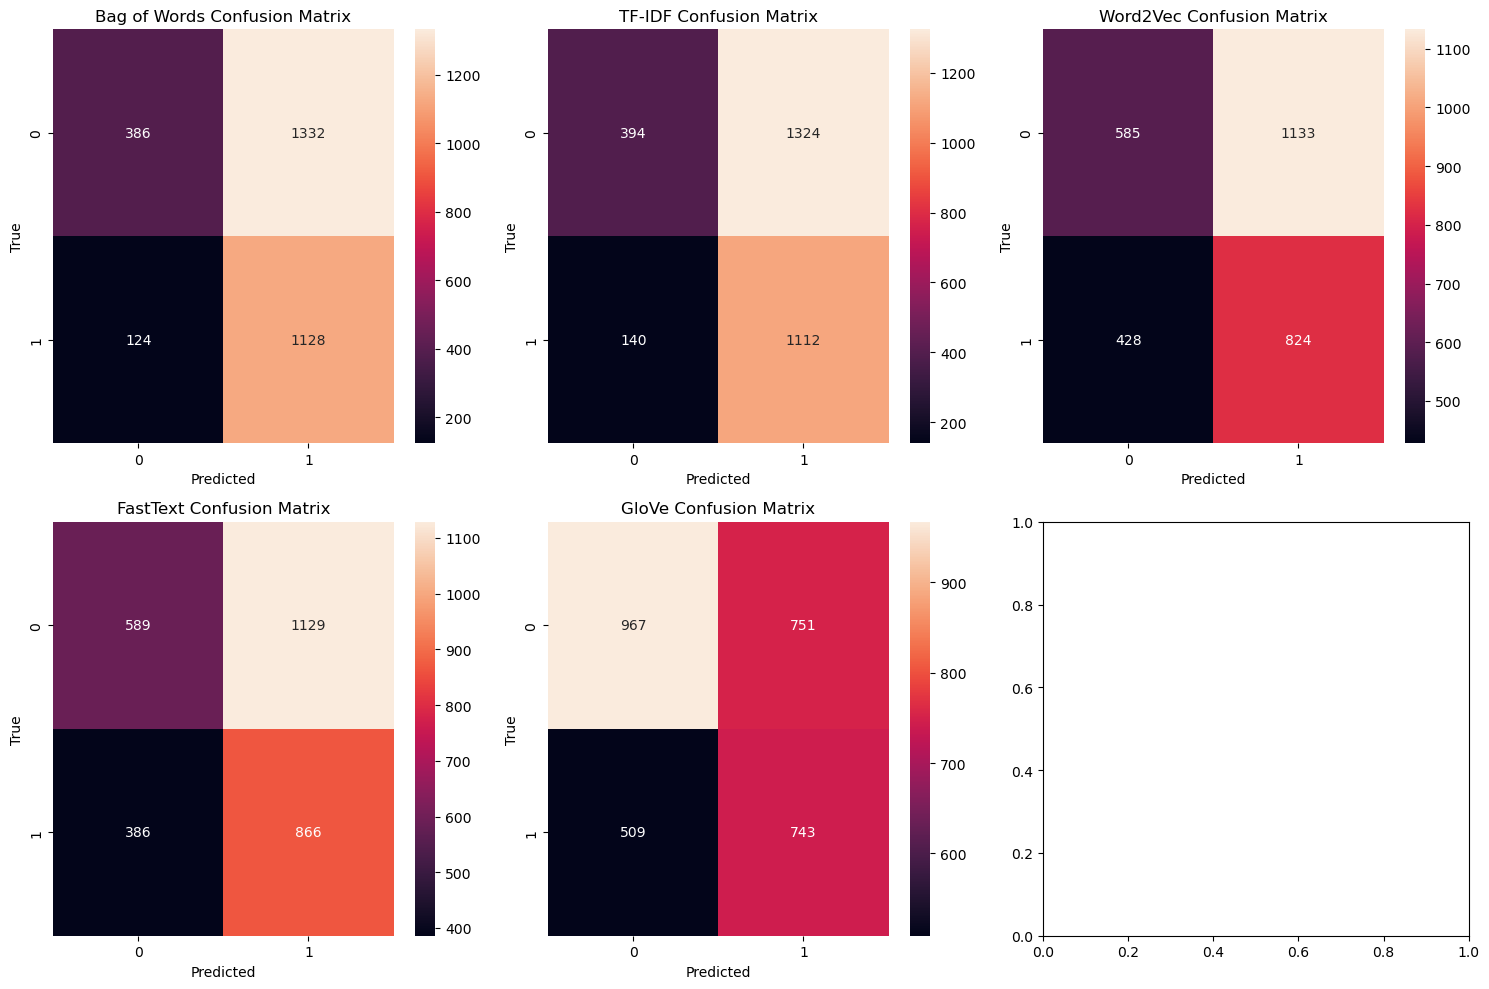

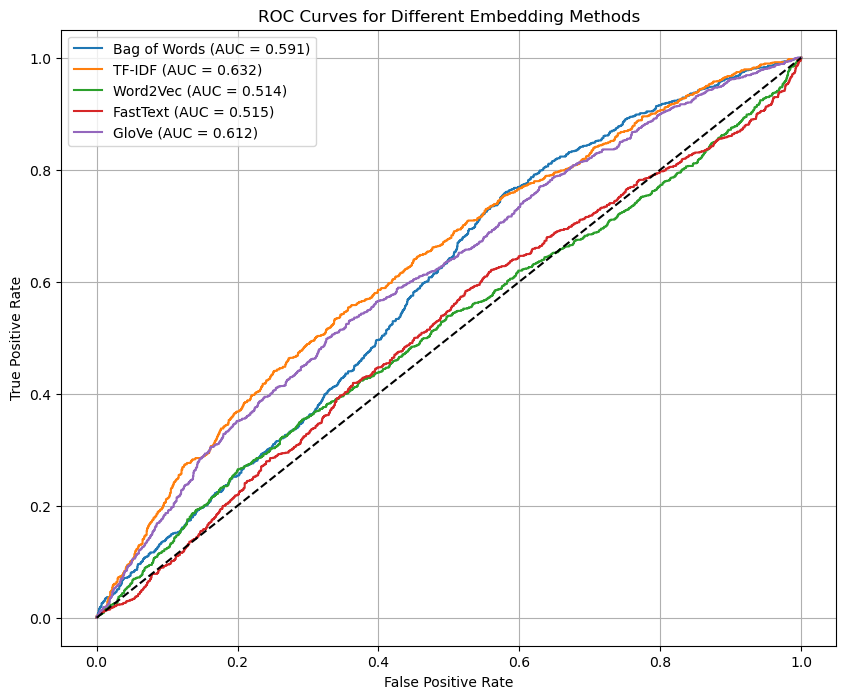

In [8]:
# Visualization functions
def evaluate_binary_classification(results):
    """Evaluate models specifically for hate speech detection"""
    evaluation = {}
    
    for method, result in results.items():
        evaluation[method] = {
            'Accuracy': result['accuracy'],
            'Hate Speech Detection Rate': result['1']['recall'],
            'False Positive Rate': 1 - result['0']['recall'],
            'Precision (Hate Speech)': result['1']['precision'],
            'F1 (Hate Speech)': result['1']['f1-score']
        }
    
    return pd.DataFrame(evaluation).round(3).T

def plot_confusion_matrices(results, y_test):
    """Plot confusion matrices for all methods"""
    n_methods = len(results)
    fig, axes = plt.subplots(2, (n_methods + 1) // 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, (method, result) in enumerate(results.items()):
        cm = confusion_matrix(y_test, result['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx])
        axes[idx].set_title(f'{method} Confusion Matrix')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('True')
    
    plt.tight_layout()
    plt.show()

def plot_roc_curves(results, y_test):
    """Plot ROC curves for all methods"""
    plt.figure(figsize=(10, 8))
    
    for method, result in results.items():
        fpr, tpr, _ = roc_curve(y_test, result['probabilities'][:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{method} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Embedding Methods')
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate and display results
hate_speech_metrics = evaluate_binary_classification(results)
display(hate_speech_metrics)
plot_confusion_matrices(results, test_df['label'])
plot_roc_curves(results, test_df['label'])